<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=0
# MODEL_USED="facebook/nllb-200-distilled-600M"
MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_arhuaco_esp_sin_dic_1_3B"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="arh_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/arh_sin_dic.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="arh"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(5672, 2)
Index(['arh', 'esp'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4537 entries, 4966 to 860
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   arh     4537 non-null   object
 1   esp     4537 non-null   object
dtypes: object(2)
memory usage: 106.3+ KB


In [9]:
df_train.head()

,arh,esp
4966,Niwisakuku Jesú zaka'nugasin ɉwa winʉnkʉsana n...,Cuando los apóstoles que estaban en Jerusalén ...
1071,"a'ga uweri nʉkeyri, kʉmeyuzey ayeygwi ɉe a'gi'...","Si ella me responde: “Bebe, y también sacaré a..."
718,"Josesin winʉnkuya ɉinari, sakuse' trigu ʉnwinʉ...",Entonces ellos cargaron el grano sobre sus asn...
4114,Ey uye'ri Jesuse' keywʉ key ie'ri: —“Tá kinki...,"Y añadió:—Jesús, acuérdate de mí cuando vengas..."
670,"Ey uye'ki Lori ɉwʉn zʉn riware'ri, Niwipaw zʉ ...","Pero como Lot titubeaba, los mensajeros los ag..."


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 567 entries, 4453 to 219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   arh     567 non-null    object
 1   esp     567 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [11]:
df_dev.head()

,arh,esp
4453,ikʉnha'se'ri: —“Sakuku emiri mowga masite gekw...,"Ellos dijeron:—¡Señor, aquí tenemos dos espada..."
101,Oh! Pinna juna chuka a’ zuna kwuyun Chuka me’z...,"¡Oh, naturaleza!, lugar de vida y alegría, te ..."
5333,ey awiki eyma cheyrwari tʉnhana gun nʉnnige'ri...,Y añadió:—Que los dirigentes de ustedes me aco...
655,"Sinkʉ ʉnzanisi twí ʉnzanikʉn pare'ri, Lori pow...",Al caer la tarde los dos mensajeros llegaron a...
1620,posuri ɉomʉ zariri aroma zʉnekʉ winʉkʉwitesi n...,"y, agarrándolo, lo arrojaron a un aljibe que e..."


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568 entries, 2515 to 4410
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   arh     568 non-null    object
 1   esp     568 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [13]:
df_test.head()

,arh,esp
2515,"Uye' María Magdalena awiri i'ngweygwi Mariari,...","Entre tanto, María Magdalena y la otra María e..."
44,"2c. iku kagumu rekumanaba kwuya-jinari, gwamu ...",estos puntos suspensivos están para representa...
4922,ey awi ingʉ ɉiwʉ bʉkʉna ka' a'nikwʉya Kawda za...,"Pasamos a sotavento de Cauda, una pequeña isla..."
3250,Ey anunaɉu nʉngwa ga'kumana ɉinari i'mʉnʉ eygw...,Los apóstoles volvieron a reunirse con Jesús y...
2656,"Inʉ awʉtari a'zʉnari, ku'nawakʉ zʉndi ʉnkʉnnis...","Acumulen, más bien, riquezas en el cielo, dond..."


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,arh,arh_words,arh_toks
4817,Esto originó graves conflictos y discusiones a...,"[Esto, originó, graves, conflictos, y, discusi...","[▁Esto, ▁origin, ó, ▁graves, ▁confli, ctos, ▁y...",Pabluri awiri Bernaweri ikʉnha'sin winʉnka'nug...,"[Pabluri, awiri, Bernaweri, ikʉnha, ', sin, wi...","[▁Pab, l, uri, ▁awiri, ▁Ber, naw, eri, ▁ik, ʉ,..."
2262,Se reunió tanta gente en torno a él que decidi...,"[Se, reunió, tanta, gente, en, torno, a, él, q...","[▁Se, ▁reuni, ó, ▁tanta, ▁gente, ▁en, ▁torno, ...","ikʉ sʉmʉ kʉnhani'kuma awʉnpare'ri, Jesuri bark...","[ikʉ, sʉmʉ, kʉnhani, ', kuma, awʉnpare, ', ri,...","[▁ik, ʉ, ▁s, ʉ, m, ʉ, ▁k, ʉ, nh, ani, ', kuma,..."
2170,"Pero Jesús, advirtiendo lo que pasaba, les dij...","[Pero, Jesús, ,, advirtiendo, lo, que, pasaba,...","[▁Pero, ▁Jesús, ,, ▁ad, virti, endo, ▁lo, ▁que...",Winyeyka Jesuse'ri winino'se'ri: —“¿Yari a'mia...,"[Winyeyka, Jesuse, ', ri, winino, ', se, ', ri...","[▁W, inye, yka, ▁Jes, use, ', ri, ▁win, ino, '..."
2180,"Al anochecer, Jesús se sentó a la mesa con los...","[Al, anochecer, ,, Jesús, se, sentó, a, la, me...","[▁Al, ▁ano, che, cer, ,, ▁Jesús, ▁se, ▁sent, ó...","Ey anawi twí ʉnzanise'ri, Jesuri i'ngwi uga mo...","[Ey, anawi, twí, ʉnzanise, ', ri, ,, Jesuri, i...","[▁Ey, ▁ana, wi, ▁tw, í, ▁, ʉ, n, zan, ise, ', ..."
3294,Oyeron estas palabras los jefes de los sacerdo...,"[Oyeron, estas, palabras, los, jefes, de, los,...","[▁O, yeron, ▁estas, ▁palabras, ▁los, ▁je, fes,...",Awi nʉngwari ikʉ winʉwiya'bari: —“Aga'kʉnamʉ d...,"[Awi, nʉngwari, ikʉ, winʉwiya, ', bari, :, —, ...","[▁Awi, ▁n, ʉ, ng, wari, ▁ik, ʉ, ▁win, ʉ, wiya,..."


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_258001/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,arh_toks,esp_words,arh_words
count,10000.000000,10000.00000,10000.000000,10000.00000
mean,33.345700,72.25660,26.652200,36.86700
std,14.759254,31.14541,11.865088,16.80376
min,2.000000,1.00000,1.000000,1.00000
25%,24.000000,51.00000,19.000000,26.00000
50%,31.000000,68.00000,25.000000,35.00000
75%,41.000000,88.00000,32.000000,45.00000
max,438.000000,542.00000,323.000000,370.00000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.2511424948034309
1.9599262212819055


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/5672 [00:00<?, ?it/s]

4369


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

["Ey uye'ki Pabluri soldadu keywʉ winʉkey ie'ri: —“Niwiri Romanu gwiri ana'nu'kino ey ʉwari chwizari powru bʉkʉnʉnke zʉn asoti niwe'sʉ anawawiri, zachʉn kineki niwinhazataku' gwawa nariri, kʉnse' ʉnniwihʉnkʉgaka anawiri; iwari mʉray ʉnchusʉn duni ki niwinhagwa'hao, ¿Azi gwa'kwa gwasiri? ¡ikʉnha kingwi zʉndi niwinha'chunhʉn rinasizari nanu'kinʉnno!” winʉkʉyana.",
 "Uye' nʉngwari Jesuse'ri: —“Nʉngwari nʉn kingwi Satanari, warin pariri ɉwí tímbiro zana nisi kʉwa'nʉya chwari awnʉnkwe” winʉkʉyana.",
 "Uye' ase'ri: —“Niwipaw zʉ ga'kʉnamʉ a'no'kwa awiri ayey ʉnchunhʉyase'ri awʉnkawari na'nʉnno” yana.Ikʉ du arunhu' neyka inʉ arunhá me'kusʉkweyna sisʉya(Mt. :-; Mar. :)",
 "paka deyru deyru kawari, koga paka, chinchinte kawi, dudute kʉzʉnnari ʉnwinga uwin a'zari faraonse'ri chuwin “a'zari re'kuwikumaye'ri”.",
 "Ey uye'ri sakuku ɉinase'ri eyma ga'kʉnamʉ Jesuse' ʉnkʉwasi asayʉwari niwise' niwinpʉsi a'zari ey yʉwani gun wina'zare'ri winto awiza wina'zare'ki; ikʉ sʉmʉ zʉna chowchu wina'kusʉya'me 

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/4369 [00:00<?, ?it/s]

3437


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/5672 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**13,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_arhuaco_esp_sin_dic_1_3B/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_arhuaco_esp_sin_dic_1_3B/spm_16k
  model_type: UNIGRAM
  vocab_size: 8192
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: naiʉwkeru'ygsmzoh,cd.tɉp"báEíJ:-NlAéúóIMSP¿?U;ɄKfLjBG()D!¡RTYFĆZHñOɈWʻʼÉÁvÍ#1x38\24657+
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2
  bos

In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-08 03:46:10--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-08 03:46:10 (75.4 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 262849
6644


2024-03-08 03:46:13.673616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 03:46:13.815108: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 03:46:14.471894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-08 03:46:14.471952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/6644 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

262849
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'arh_Latn', '<mask>']
[262847, 262848, 262849]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

262848 262663


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 262850. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(262850, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['Al anochecer, Jesús se sentó a la mesa con los Doce'], ["Ey anawi twí ʉnzanise'ri, Jesuri i'ngwi uga mowga kʉtow kʉriwiya ɉinasin mesase' winasi,"], 'spa_Latn', 'arh_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 9.879865646362305
1000 4.482493012428284
2000 2.679631873488426
3000 1.9305044021010398
4000 1.3628304750919342
5000 0.9630590504854918
6000 0.7052046181187034
7000 0.5646577081680297
8000 0.4501689221672714
9000 0.34339481907710434
10000 0.2848906906377524
11000 0.2340163647066802
12000 0.1825876977350563
13000 0.14366599721834064
14000 0.11253687469661236
15000 0.09006621156726033
16000 0.07723594467807561
17000 0.06492905292473733
18000 0.056797460774891076
19000 0.05153830784931779
20000 0.046293974542059003
21000 0.04420671386178583
22000 0.03927675227401778
23000 0.037916588577907535
24000 0.035873073193244634
25000 0.03383890302316286
26000 0.032267229463439434
27000 0.0318612582734786
28000 0.030622395899379626
29000 0.028553091273410245
30000 0.028274791226023808
31000 0.027149506265064703
32000 0.026109493545023725
33000 0.02624852309934795
34000 0.025275114245712757
35000 0.023172197126899847
36000 0.022883420597645455
37000 0.022402570463251323
38000 0.02095070155186113
3

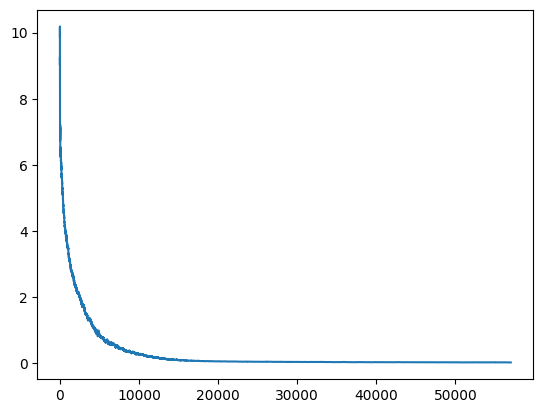

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['A lo que Efrón respondió:']
["Ey uye' nʉngwa Efrónse' keywʉ key ie'ri:"]
["Ey uye' nʉngwa Efrónri:"]


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x 2 americasnlp americasnlp 4.0K Mar  7 12:19 .
4.0K drwxrwxr-x 8 americasnlp americasnlp 4.0K Mar  8 15:54 ..
960K -rw-rw-r-- 1 americasnlp americasnlp 960K Mar  8 03:46 all_texts_file.csv
4.0K -rw-rw-r-- 1 americasnlp americasnlp  848 Mar  8 18:29 config.json
4.0K -rw-rw-r-- 1 americasnlp americasnlp  184 Mar  8 18:29 generation_config.json
5.2G -rw-rw-r-- 1 americasnlp americasnlp 5.2G Mar  8 18:29 pytorch_model.bin
4.8M -rw-rw-r-- 1 americasnlp americasnlp 4.8M Mar  8 18:29 sentencepiece.bpe.model
4.0K -rw-rw-r-- 1 americasnlp americasnlp 3.5K Mar  8 18:29 special_tokens_map.json
376K -rw-rw-r-- 1 americasnlp americasnlp 373K Mar  8 03:46 spm_16k.model
148K -rw-rw-r-- 1 americasnlp americasnlp 148K Mar  8 03:46 spm_16k.vocab
4.8M -rw-rw-r-- 1 americasnlp americasnlp 4.8M Mar  8 03:46 spm_nllb_268k.model
4.0K -rw-rw-r-- 1 americasnlp americasnlp  570 Mar  8 18:29 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

["Nʉgunamu wa'ku neyka ɉinaGa'kʉnamʉ unarwási awʉ' niwe'zari michwawin"]


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

["Jwia'lezanu gun nanun nuzato me'zanéy na'zari"]

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['los padres de familia tendrán derecho de escoger el tipo de educación para sus hijos menores. en los establecimientos del estado ninguna persona podrá ser obligada a recibir educación religiosa.']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['los padres de familia tendrán derecho de escoger el tipo de educación para sus hijos menores. en los establecimientos del estado ninguna persona podrá ser obligada a recibir educación religiosa.']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/568 [00:00<?, ?it/s]

  0%|          | 0/568 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 8.19 28.7/8.3/5.0/3.7 (BP = 1.000 ratio = 1.000 hyp_len = 15033 ref_len = 15030)
chrF2++ = 23.80
BLEU = 8.75 30.3/11.0/5.7/3.4 (BP = 0.981 ratio = 0.981 hyp_len = 14103 ref_len = 14379)
chrF2++ = 33.38


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,arh,esp,arh_translated,esp_translated
748,Uye'ri Judase'ri: —“¿Inʉ nʉkʉchusanʉndi me'zano?” key ie'ri: —“Seyu awiri ʉya sí mikʉbenuga mika...,Judá preguntó:—¿Qué quieres que te deje?Ella respondió:—Tu sello con su cordón y el bastón que l...,"Uye' nʉngwari Judári: - ""¿Azi minhawkwa me'ɉuno?"" key ie'ri, Lease'ri: - ""Nʉɉurí ʉwa'ba, kʉmeyu ...",Judá respondió: - Deja que el muchacho venga bajo mi cuidado y pongámonos inmediatamente en marc...
1350,"Ey anunaɉu nʉngwa Israerise' keywʉ key ie'ri: —“Tá kinki, iwa nʉngwa eyki nʉkuyʉn ʉnna'zʉn gun a...",Entonces Israel dijo a José:—Ahora ya puedo morir. Te he visto y sé que estás vivo.,"Ey uye' nʉngwa Israeri José keywʉ key ie'ri: - ""Iwa ɉwía ʉnnʉwicha gun anawaki ʉnnukʉndi, mákich...",Y Jacob se enteró de que su padre había muerto. Entonces su padre le dijo: - Tal vez me matarás.
4309,"Ey anunaɉu nʉngwari asige' ɉirʉgakakʉ pari ʉndiyunʉn nuse'ri, ikʉ zʉgurókʉchʉ Jesusin winʉnka'r...","Al día siguiente, cuando bajaron del monte, mucha gente salió al encuentro de Jesús.","Ey anawi asige' bunsi ʉnchare'ri, kwimʉkʉnʉ pari ʉndiyunʉn rinuse'ri, ikʉ sʉmʉ kʉnhani'kuma una.","Al día siguiente, cuando Jesús salía de la montaña, la gente se apiñaba a su alrededor deseosa."
2499,Ey awi ɉwiku' pari ratrekindi ka'gʉmʉse'ri aɉu yow twí zanika una.,"Desde el mediodía, toda la tierra quedó sumida en oscuridad hasta las tres de la tarde.","Uye'ri ayʉnke rinukʉn nugase' winino'kuye'ri: - ""Profeta Elíae kʉkanʉn nusi zʉn eiya niná wingwa...",Jesús le contestó: - Te aseguro que hoy estarás conmigo en el paraíso.Muerte de Jesús
33,"emi akwey zoyeyka, yow, paperi asamu yamu awiukwa, ingwiri gugín (guchu) unnuku name, kwa gugín ...",para hacer efectiva la protección de estos derechos existen unos mecanismos que podemos utilizar...,"1. michwi enanuyáy winíkwuya. eymari: 1. sakuku ingwi umún azuna neykase (acta de tutela), 2. sa...",los padres de familia tendrán derecho de escoger el tipo de educación para sus hijos menores. en...
1419,Ey uye' nʉngwa Jakobuse' key ie'ri: —“Sanusi má gʉmʉsinʉ umʉn na'zʉnazey inʉ duna nipanʉngwa mik...,"Jacob insistió:—Júramelo antes.Esaú se lo juró, y de ese modo le vendió a Jacob sus derechos de ...","Ey uye'ki Jakobuse'ri, kʉriwiya ɉina umʉn a'zʉna umʉnb na'ba umʉngwi una, sakuku umʉnte wina'zʉn...","Jacob respondió: - Soy Esaú, tu primogénito, y debes venir.Él respondió: - Vengo huyendo de mi p..."
5135,Ey awi Perge ga'kʉnamʉ winbasanaɉuri eygwi Atalía rizoyana.,Anunciaron el mensaje en Perge y bajaron a Atalía.,Awi nʉngwa Berge ayekʉ ga'kʉnamʉ duna zakʉ winʉka'cho'si nʉngwari Atalía ʉndizoya una.,"Se embarcaron allí para Antioquía de Siria, donde los habían confiado a la protección de Dios."
4071,"Uye'ki nowmisinʉri eygwi ie'ri: —“Kakʉ Abraan eymí nʉngwa riniku' rinariza'chʉ, ʉwe'ki i'ngwi ʉ...","El rico replicó: «No, padre Abrahán, solo si alguno de los que han muerto va a hablarles, se con...","Uye'ki nowmisinʉse' eygwi key ie'ri: - ""Ʉnne'ki, kakʉ Abraandi, tá winʉnha'chu' ne awʉnki someth...","Los ricos dijeron: ""Señor, ¡pero si ya tiene diez veces más!""."
3922,"Ey ʉweri du winʉ kʉno'kwa ú, emey gwi nari ingʉ kindi ey kʉnʉnase'ri eygwi kawʉ ka'sari ukumu'n...","Presten mucha atención, porque al que tenga algo, aún se le dará más; pero al que no tenga nada,...","¡Azi kindi ey kʉnʉn nuga neki miwe'zanu' kinó! Ka'gʉmʉse'ri eygwi kawʉ ka'sari ukumu'nʉnno, ʉwe'...","¡Ay de ustedes, maestros de la ley y fariseos hipócritas, que ofrecen a Dios el diezmo de la men..."
742,"Ingʉ birin ʉnzanika uye'ri, Judá zʉ kʉsaw Súa zʉ bu'gʉmʉri, ʉnwicha una, ey awi Judári iawichana...","Después de mucho tiempo, murió la mujer de Judá, la hija de Súa. Pasado el duelo por ella, subió...","Ey awi ingʉ birin ʉnzanikʉn nuse'ri, Judá zʉ kʉsaw, Disón zʉ bu'gʉmʉ ʉnwicha anuye'ri, Judári aɉ...","Un día, la hija de Judá murió y se acostó con la viuda, y así lo pasó con acostarse con ella. En..."
